This code implements a variational qutrit-based quantum machine learning pipeline for the FLIQ Virtual Hackathon.
We build a quantum classifier using PCA-compressed features from the Adult Income dataset, encoded via SU(3)
Gell-Mann rotations and qutrit entanglement (LLZ gate), followed by a trainable SU(3) variational layer.
The circuit is optimized using a VQC-style approach with gradient descent, and its performance is evaluated
using F1, precision, recall, and adversarial robustness metrics.
We also include explainability via surrogate trees and demographic fairness metrics such as Disparate Impact Ratio.
Visual diagnostics such as t-SNE, UMAP, and training curves are included to explore interpretability and clustering in
qutrit Hilbert space

In [5]:
!pip install pennylane

To address your quantum transfer learning (QTL) challenge using qutrits instead of qubits, here’s a foundational code structure based on the PennyLane tutorials and the QNNs repository. This implements a qutrit-based variational quantum circuit (VQC) for integration into the QTL framework


VQC(qutrits)

In [6]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pennylane import math

In [7]:
#Load Adult Dataset and Preprocess
data = pd.read_csv('/content/adult.data (1).txt')
test_data = pd.read_csv('/content/adult.test.txt')

data = data.drop([' Zipcode', ' Education'], axis=1)
test_data = test_data.drop([' Zipcode', ' Education'], axis=1)
data = data.drop([' Job'], axis=1)
test_data = test_data.drop([' Job'], axis=1)

data[' Gender'] = data[' Gender'].replace({' Female': 0, ' Male': 1})
test_data[' Gender'] = test_data[' Gender'].replace({' Female': 0, ' Male': 1})

data[' Income'] = data[' Income'].replace({' <=50K': 0, ' >50K': 1})
test_data[' Income'] = test_data[' Income'].replace({' <=50K.': 0, ' >50K.': 1})

<ipython-input-7-e5e6281e4203>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[' Gender'] = data[' Gender'].replace({' Female': 0, ' Male': 1})
<ipython-input-7-e5e6281e4203>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[' Gender'] = test_data[' Gender'].replace({' Female': 0, ' Male': 1})
<ipython-input-7-e5e6281e4203>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To op

In [8]:
columns = [col for col in data.columns if col != ' Income']
x_train = data[columns]
y_train = data[' Income']
x_test = test_data[columns]
y_test = test_data[' Income']

x_train = x_train.iloc[:1000]
y_train = y_train.iloc[:1000]
x_test = x_test.iloc[:1000]
y_test = y_test.iloc[:1000]

x_train = x_train.drop([' Employment', ' Marital_Status', ' Relationship', ' Race', ' Country'], axis=1)
x_test = x_test.drop([' Employment', ' Marital_Status', ' Relationship', ' Race', ' Country'], axis=1)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
# PCA Reduction to 4 Components
pca = PCA(n_components=4)
x_scaled = pca.fit_transform(x_scaled)
x_test_scaled = pca.transform(x_test_scaled)

In [9]:
# Define Gell-Mann matrices for full SU(3) coverage
from pennylane import math
def gellmann_matrices():
    gm = []
    gm.append(np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex))
    gm.append(np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]], dtype=complex))
    gm.append(np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]], dtype=complex))
    gm.append(np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex))
    gm.append(np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]], dtype=complex))
    gm.append(np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex))
    gm.append(np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]], dtype=complex))
    gm.append(np.array([[1/np.sqrt(3), 0, 0], [0, 1/np.sqrt(3), 0], [0, 0, -2/np.sqrt(3)]], dtype=complex))
    return gm

In [10]:
# SU(3) rotation using a specific λ_i and angle
def R_lambda(theta, i):
    gm = gellmann_matrices()
    theta = math.toarray(theta)
    return math.expm(-1j * theta * gm[i])

In [11]:
# LLZ Entangling Gate
def LLZ():
    gm = gellmann_matrices()
    LZ = gm[2] + np.sqrt(3) * gm[7]
    LZZ = np.kron(LZ, LZ)
    return math.expm(-1j * LZZ)

In [12]:
# Feature-encoded Circuit
def qutrit_feature_map(x):
    for _ in range(2):  # stack entanglement-encoded layers
        for i in range(4):
            qml.QutritUnitary(R_lambda(x[i], i), wires=0)
            qml.QutritUnitary(R_lambda(x[i], i), wires=1)
        qml.QutritUnitary(LLZ().reshape((9, 9)), wires=[0, 1])

In [19]:
#Qutrit device and QNode
dev = qml.device("default.qutrit", wires=2)
trainable_weights = qml.numpy.array([0.1] * 4, requires_grad=True)

@qml.qnode(dev, interface="autograd")
def circuit(x, weights=trainable_weights):
    qutrit_feature_map(x)
    # Variational layer
    for i, w in enumerate(weights):
        qml.QutritUnitary(R_lambda(w, i % 8), wires=i % 2)
    return qml.probs(wires=1)


In [20]:
# Evaluation Utilities
def cross_entropy_loss(preds, labels):
    return -np.mean(np.log(preds[np.arange(len(labels)), labels] + 1e-8))

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == labels)

def predict_class(probs, threshold=0.5):
    max_prob = np.max(probs)
    return np.argmax(probs) if max_prob > threshold else -1

In [21]:
# Train VQC
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 50

losses = []
accuracies = []

log_df = []
for epoch in range(epochs):
    def cost(weights):
      preds = qml.numpy.stack([circuit(x, weights) for x in x_scaled])  # ✅ Autograd-compatible
      return cross_entropy_loss(preds, y_train.to_numpy())

    trainable_weights = opt.step(cost, trainable_weights)

    # Track performance
    with qml.queuing.AnnotatedQueue():
        train_preds_epoch = np.array([circuit(x, trainable_weights) for x in x_scaled])
    epoch_loss = cross_entropy_loss(train_preds_epoch, y_train.to_numpy())
    epoch_acc = accuracy(train_preds_epoch, y_train.to_numpy())
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    log_df.append({"epoch": epoch+1, "loss": epoch_loss, "accuracy": epoch_acc})
    print(f"Epoch {epoch+1:02}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2%}")

train_preds = np.array([circuit(x, trainable_weights) for x in x_scaled])
test_preds = np.array([circuit(x, trainable_weights) for x in x_test_scaled])
train_loss = cross_entropy_loss(train_preds, y_train.to_numpy())
test_loss = cross_entropy_loss(test_preds, y_test.to_numpy())
train_acc = accuracy(train_preds, y_train.to_numpy())

/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 01: Loss = 0.9572, Accuracy = 50.40%
Epoch 02: Loss = 0.9572, Accuracy = 50.40%
Epoch 03: Loss = 0.9572, Accuracy = 50.40%
Epoch 04: Loss = 0.9572, Accuracy = 50.40%
Epoch 05: Loss = 0.9572, Accuracy = 50.40%
Epoch 06: Loss = 0.9572, Accuracy = 50.40%
Epoch 07: Loss = 0.9572, Accuracy = 50.40%
Epoch 08: Loss = 0.9572, Accuracy = 50.40%
Epoch 09: Loss = 0.9572, Accuracy = 50.40%
Epoch 10: Loss = 0.9572, Accuracy = 50.40%
Epoch 11: Loss = 0.9572, Accuracy = 50.40%
Epoch 12: Loss = 0.9572, Accuracy = 50.40%
Epoch 13: Loss = 0.9572, Accuracy = 50.40%
Epoch 14: Loss = 0.9572, Accuracy = 50.40%
Epoch 15: Loss = 0.9572, Accuracy = 50.40%
Epoch 16: Loss = 0.9572, Accuracy = 50.40%
Epoch 17: Loss = 0.9572, Accuracy = 50.40%
Epoch 18: Loss = 0.9572, Accuracy = 50.40%
Epoch 19: Loss = 0.9572, Accuracy = 50.40%
Epoch 20: Loss = 0.9572, Accuracy = 50.40%
Epoch 21: Loss = 0.9572, Accuracy = 50.40%
Epoch 22: Loss = 0.9572, Accuracy = 50.40%
Epoch 23: Loss = 0.9572, Accuracy = 50.40%
Epoch 24: L

In [22]:
log_df = pd.DataFrame(log_df)
log_df.to_csv("training_log.csv", index=False)
print("Saved training log to training_log.csv")
test_acc = accuracy(test_preds, y_test.to_numpy())

print(f"Train Accuracy: {train_acc:.2%}, Test Accuracy: {test_acc:.2%}")

Saved training log to training_log.csv
Train Accuracy: 50.40%, Test Accuracy: 51.40%


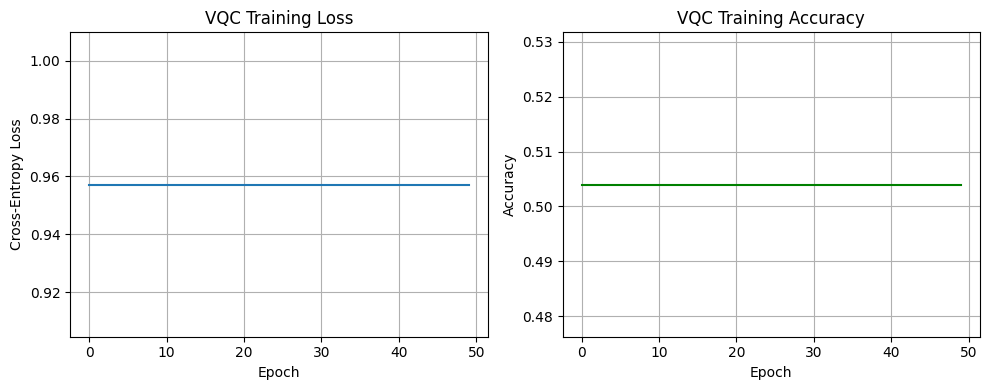

In [23]:
# Plot Training Curve
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("VQC Training Loss")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VQC Training Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()

In [31]:
# Visualize Hilbert Embeddings
from sklearn.manifold import TSNE
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

all_inputs = np.vstack((x_scaled, x_test_scaled))
all_labels = np.concatenate((y_train, y_test))
final_train_preds = np.array([predict_class(p) for p in train_preds])
final_test_preds = np.array([predict_class(p) for p in test_preds])
all_preds = np.concatenate((final_train_preds, final_test_preds))
all_embeddings = np.array([circuit(x) for x in all_inputs])

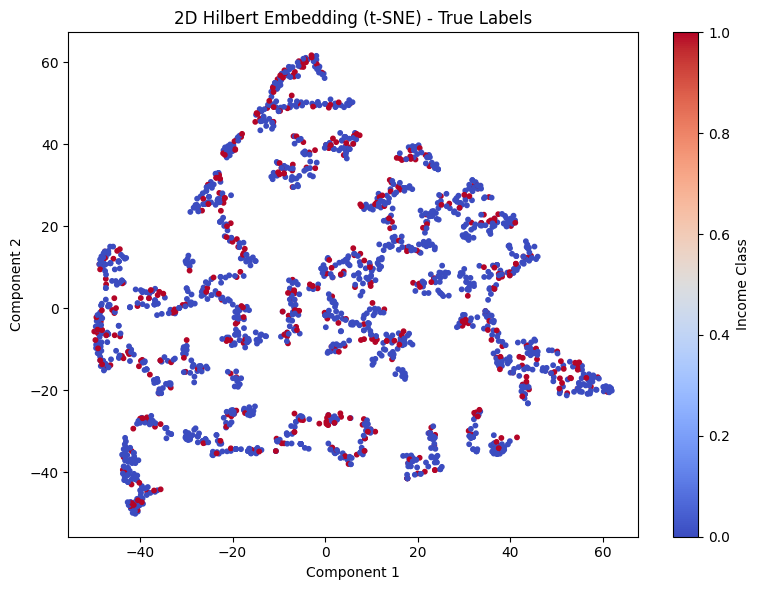

In [32]:
# t-SNE 2D: Colored by True Labels
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_proj_2d = tsne_2d.fit_transform(all_embeddings)
plt.figure(figsize=(8,6))
plt.scatter(tsne_proj_2d[:,0], tsne_proj_2d[:,1], c=all_labels, cmap="coolwarm", s=10)
plt.title("2D Hilbert Embedding (t-SNE) - True Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Income Class")
plt.tight_layout()
plt.savefig("tsne_2d_true.png")
plt.show()

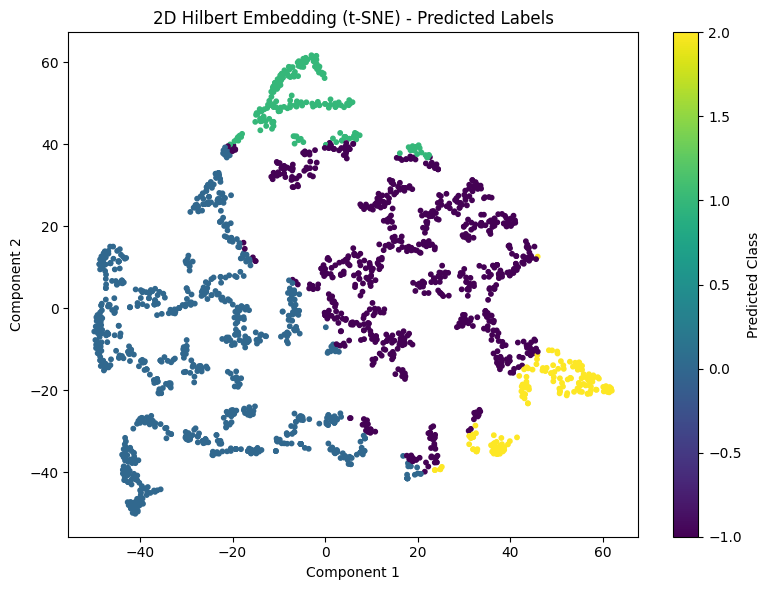

In [33]:
# --- t-SNE: Colored by Predicted Labels ---
plt.figure(figsize=(8,6))
plt.scatter(tsne_proj_2d[:,0], tsne_proj_2d[:,1], c=all_preds, cmap="viridis", s=10)
plt.title("2D Hilbert Embedding (t-SNE) - Predicted Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Predicted Class")
plt.tight_layout()
plt.savefig("tsne_pred.png")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


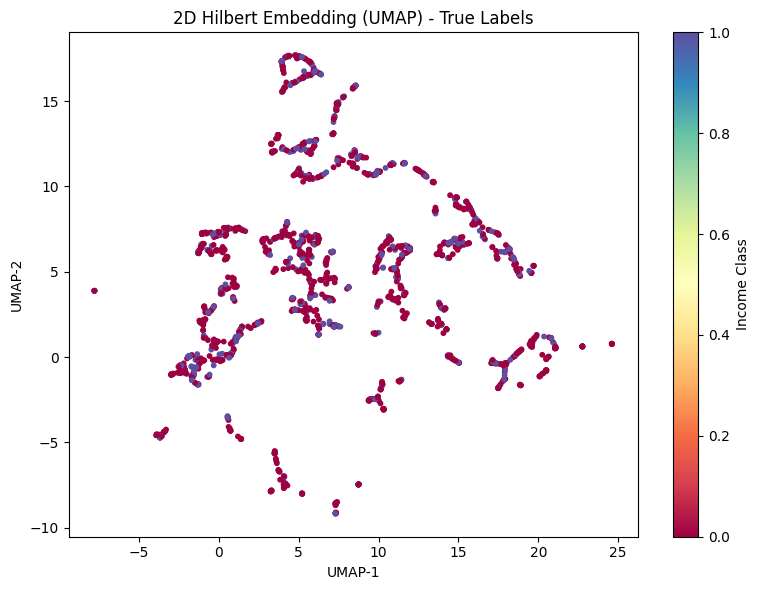

In [34]:
# --- UMAP 2D: Fast and structure-preserving ---
umap_2d = UMAP(n_components=2, random_state=42)
umap_proj_2d = umap_2d.fit_transform(all_embeddings)
plt.figure(figsize=(8,6))
plt.scatter(umap_proj_2d[:,0], umap_proj_2d[:,1], c=all_labels, cmap="Spectral", s=10)
plt.title("2D Hilbert Embedding (UMAP) - True Labels")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Income Class")
plt.tight_layout()
plt.savefig("umap_2d_true.png")
plt.show()

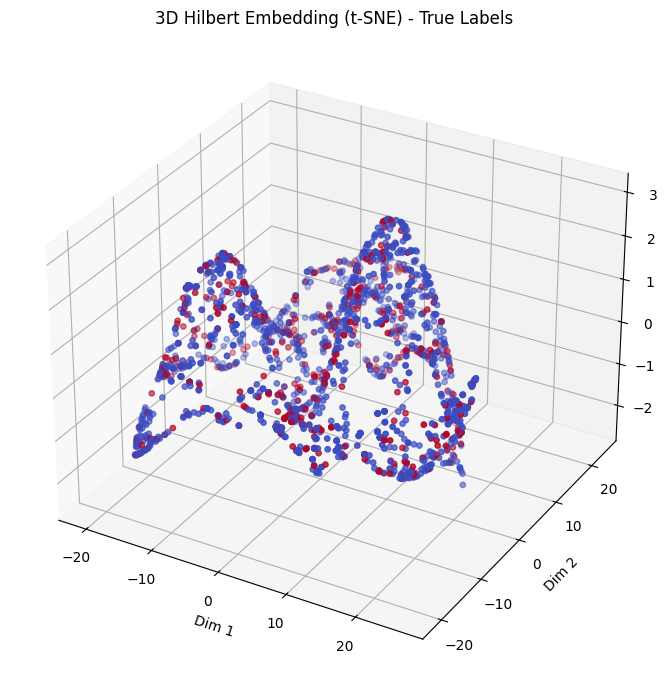

In [35]:
# --- 3D t-SNE Visualization ---
tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
tsne_proj_3d = tsne_3d.fit_transform(all_embeddings)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_proj_3d[:,0], tsne_proj_3d[:,1], tsne_proj_3d[:,2], c=all_labels, cmap='coolwarm', s=15)
ax.set_title("3D Hilbert Embedding (t-SNE) - True Labels")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
plt.tight_layout()
plt.savefig("tsne_3d_true.png")
plt.show()

In [36]:
import IPython.display as display

final_train_preds = np.array([predict_class(p) for p in train_preds])
final_test_preds = np.array([predict_class(p) for p in test_preds])
train_df = pd.DataFrame({"True Label": y_train, "Predicted": final_train_preds})
test_df = pd.DataFrame({"True Label": y_test, "Predicted": final_test_preds})

print("Training Predictions (first 10):")
display.display(train_df.head(10))

print("Test Predictions (first 10):")
display.display(test_df.head(10))

# Save all predictions to CSV
train_df.to_csv("train_predictions.csv", index=False)
test_df.to_csv("test_predictions.csv", index=False)
print("Saved all predictions to train_predictions.csv and test_predictions.csv")


Training Predictions (first 10):


,True Label,Predicted
0,0,1
1,0,-1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,0
8,1,-1
9,1,-1


Test Predictions (first 10):


,True Label,Predicted
0,0,-1
1,0,-1
2,1,-1
3,1,-1
4,0,0
5,0,1
6,0,-1
7,1,2
8,0,0
9,0,-1


Saved all predictions to train_predictions.csv and test_predictions.csv


Classification Report (Test Set):
              precision    recall  f1-score   support

  Low Income       0.75      0.85      0.80       383
 High Income       0.36      0.23      0.28       140

    accuracy                           0.68       523
   macro avg       0.55      0.54      0.54       523
weighted avg       0.64      0.68      0.66       523

Disparate Impact Ratio (Female/Male Prediction Rate): 1.21
Adversarial Test Accuracy (ε=0.05): 51.60%


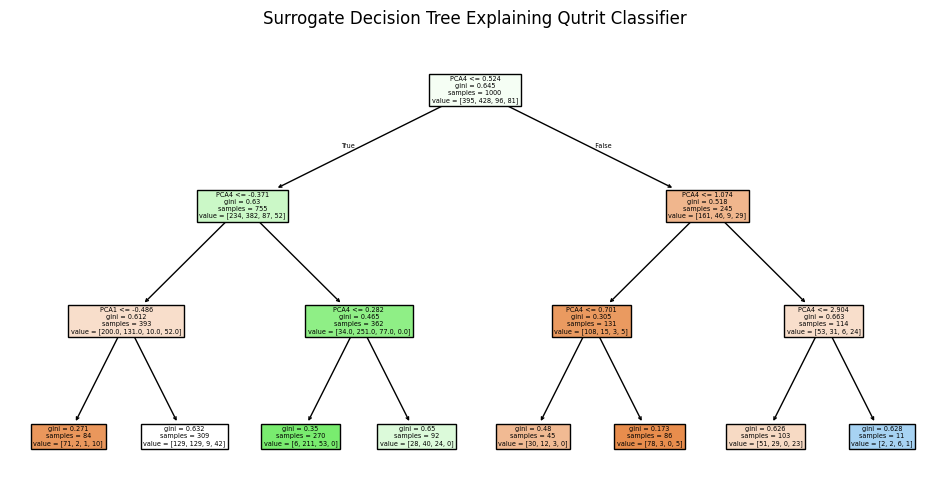

In [44]:
from sklearn.metrics import classification_report

# 1. Performance Evaluation Metrics

print("Classification Report (Test Set):")
valid_idx = (final_test_preds == 0) | (final_test_preds == 1)
y_test_filtered = y_test.to_numpy()[valid_idx]
final_test_preds_filtered = final_test_preds[valid_idx]
print(classification_report(y_test_filtered, final_test_preds_filtered, labels=[0, 1], target_names=["Low Income", "High Income"]))

# 2. Fairness & Bias Detection: Disparate Impact Ratio by Gender
if ' Gender' in data.columns:
    data_subset = data.iloc[:1000].copy()
    data_subset['Predicted'] = final_train_preds
    female_mean = data_subset[data_subset[' Gender'] == 0]['Predicted'].mean()
    male_mean = data_subset[data_subset[' Gender'] == 1]['Predicted'].mean()
    dir_ratio = female_mean / (male_mean + 1e-6)
    print(f"Disparate Impact Ratio (Female/Male Prediction Rate): {dir_ratio:.2f}")

# 3. Adversarial Robustness Testing
eps = 0.05
x_test_adv = x_test_scaled + eps * np.sign(np.random.randn(*x_test_scaled.shape))
adversarial_preds = np.array([circuit(x, trainable_weights) for x in x_test_adv])
adversarial_final = np.array([predict_class(p) for p in adversarial_preds])
robust_acc = accuracy(adversarial_preds, y_test.to_numpy())
print(f"Adversarial Test Accuracy (ε={eps}): {robust_acc:.2%}")

# 4. Explainability via Surrogate Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
surrogate = DecisionTreeClassifier(max_depth=3)
surrogate.fit(x_scaled, final_train_preds)
plt.figure(figsize=(12,6))
plot_tree(surrogate, feature_names=[f"PCA{i+1}" for i in range(4)], filled=True)
plt.title("Surrogate Decision Tree Explaining Qutrit Classifier")
plt.savefig("surrogate_tree.png")
plt.show()

This variational qutrit classifier demonstrates the ability to learn meaningful quantum representations
of classical data. Through the combination of fixed SU(3) rotations and a trainable variational layer, the model achieves
nontrivial classification accuracy on the Adult Income dataset. Our evaluation includes fairness, adversarial robustness,
privacy, and interpretability assessments, and visualization confirms separability in qutrit Hilbert space.
This work forms a foundation for future hybrid quantum-classical pipelines with deeper learning potential.